# Разработка рекомендательного алгоритма для читателей библиотеки

##### Александр Тиунов
##### 2022 г.

<h1>Оглавление<span class="tocSkip"></span></h1>

*  [Условие задачи](#Условие-задачи)
*  [Загрузка данных](#Загрузка-данных)
*  [Изучение данных](#Изучение-данных)
    *  [Проверка дубликатов](#Проверка-дубликатов)
    *  [Определим число строк в таблицах](#Определим-число-строк-в-таблицах)
*  [Добавление информации о количестве взятых книг](#Добавление-информации-о-количестве-взятых-книг)
*  [Добавление рейтинга книг](#Добавление-рейтинга-книг)
*  [Создание частотного списка](#Создание-частотного-списка)
*  [Построение модели с помощью алгоритма ALS](#Построение-модели-с-помощью-алгоритма-ALS)
*  [Метрика](#Метрика)

## Условие задачи
Участникам необходимо для каждого из 16 753 пользователей сделать
подборку из 20 рекомендаций. Порядок рекомендаций не учитывается, но
очень важно, чтобы рекомендации основывались на интересе пользователя
и были ему релевантны. Обратите внимание, что тестирующая система
принимает только те решения, в которых содержится не более 20
рекомендаций для одного пользователя. Уникальных документов – 354 355.
Участники получают 3 таблицы: users.csv, items.csv,
train_transactions.csv. Users.csv содержит информацию о читателях, где
каждый читатель имеет свой уникальный номер читательского билета (chb).
Таблица items.csv, содержит описание документов, которые доступны всем
читателям, каждый документ имеет уникальный системный номер
(sys_numb). Таблица train_transactions.csv устанавливает связь между
users-items, показывает наличие взаимодействия читателя с документом.\
Описание входных значений\
**users.csv**:\
chb – полный номер читательского билета
age – возраст читателя
gender – пол читателя
chit_type – тип читателя\
**items.csv**:\
sys_numb – системный номер документа
title – название документа
author – автор документа
izd – издательство
year_izd – год издания
bbk – ББК документа\
**train_transactions.csv**:\
chb - полный номер читательского билета
sys_numb – системный номер документа
date_1 – дата выдачи
is_real – был ли выдан заказ
type – тип книговыдачи (книговыдача/скачивание)
source – источник (один из трёх онлайн-просмотрщиков)
is_printed – печатный/электронный документ

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Загрузка данных

In [2]:
#считывание данных
users = pd.read_csv('train/users.csv', sep=';', index_col=None, dtype={'age': str, 'chb': str, 'chit_type': str, 'gender': str})
items = pd.read_csv('train/items.csv', sep=';', index_col=None, dtype={'author': str, 'bbk': str, 'izd': str, 'sys_numb': str, 'title': str, 'year_izd': str})
train = pd.read_csv('train/train_transactions_extended.csv', sep=';', index_col=None, dtype={'chb': str, 'date_1': str, 'is_printed': str, 'is_real': str, 'source': str, 'sys_numb': str, 'type': str})

# Изучение данных

In [3]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', None)

In [4]:
#посмотрим содержимое таблиц
users

,chb,age,gender,chit_type
0,300001020830,21,female,нет данных
1,300001113642,36,female,нет данных
2,300001148466,46,female,нет данных
3,300001117011,22,female,нет данных
4,200001038094,24,female,echb
...,...,...,...,...
16748,300001154270,45,female,нет данных
16749,200000851690,40,female,нет данных
16750,200001154993,29,male,нет данных
16751,200001155169,31,male,echb


In [5]:
items[items['sys_numb'] == 'RSL07000456796'].sort_values('sys_numb')

,sys_numb,title,author,izd,year_izd,bbk
93032,RSL07000456796,отсутствует,отсутствует,отсутствует,отсутствует,отсутствует


In [6]:
items.nunique()

sys_numb    354355
title       319821
author      172622
izd          36909
year_izd      2505
bbk         130779
dtype: int64

In [7]:
#проверка пропущенных данных
for col in items.columns:
    pct_missing = np.mean(items[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

sys_numb - 0%
title - 0%
author - 0%
izd - 0%
year_izd - 0%
bbk - 0%


In [8]:
# число взаимодействий пользователя 100000834421 
train[train['chb'] == '100000834421'].sort_values('sys_numb')

,chb,sys_numb,date_1,is_real,type,source,is_printed
6567,100000834421,RSL07000424807,2021-10-22,yes,книговыдача,2DL.Viewer,False
6573,100000834421,RSL07000432551,2021-10-22,yes,книговыдача,2DL.Viewer,False
6570,100000834421,RSL07000432552,2021-10-22,yes,книговыдача,2DL.Viewer,False
6571,100000834421,RSL07000432553,2021-10-22,yes,книговыдача,2DL.Viewer,False
6572,100000834421,RSL07000440441,2021-10-22,yes,книговыдача,2DL.Viewer,False
6568,100000834421,RSL07000456796,2021-10-18,yes,книговыдача,2DL.Viewer,False
6569,100000834421,RSL07000474065,2021-10-18,yes,книговыдача,2DL.Viewer,False


взаимодействий читателя с книгами может быть меньше 20, при этом книги могут быть как выданы, так и не выданы

## Проверка дубликатов

In [9]:
print('Количество дубликатов в users равно', users.duplicated().sum())

Количество дубликатов в users равно 0


In [10]:
print('Количество дубликатов в items равно', items.duplicated().sum())

Количество дубликатов в items равно 0


In [11]:
print('Количество дубликатов в train равно', train.duplicated().sum())

Количество дубликатов в train равно 0


##### Вывод - Дубликатов в таблицах нет, все записи уникальны

# Определим число строк в таблицах

In [12]:
print(f"Кол-во пользователей: {len(train['chb'].unique())}")
print(f"Кол-во документов в истории пользователей: {len(train['sys_numb'].unique())}")
print(f"Общее кол-во документов: {len(items['sys_numb'].unique())}")

Кол-во пользователей: 16753
Кол-во документов в истории пользователей: 194666
Общее кол-во документов: 354355


In [13]:
#строго фиксируем кол-во пользователей и уникальных документов
n_users = len(train['chb'].unique())
n_items = len(items['sys_numb'].unique())

In [14]:
print(n_users, n_items)

16753 354355


# Добавление информации о количестве взятых книг

In [15]:
#Посмотрим сколько раз пользователи берут одну и ту же книгу
train_transactions = train[['chb', 
                            'sys_numb']].groupby(['chb', 'sys_numb']).size().to_frame('taked').reset_index()

In [16]:
# проверим дубликаты
train_transactions.sort_values('sys_numb').duplicated().sum()

0

In [17]:
# посмотрим содержимое 
train_transactions.sort_values('taked')

,chb,sys_numb,taked
0,100000641403,RSL01000769304,1
148355,300000865816,RSL01009576028,1
148357,300000865827,RSL01002306569,1
148358,300000865827,RSL01002589369,1
148359,300000865827,RSL01002617583,1
...,...,...,...
144698,300000850004,RSL01002745675,26
80884,200000957291,RSL01006724299,35
144763,300000850004,RSL01010175347,35
86257,200000987642,RSL01004357029,42


In [18]:
# если рейтинг больше 20 заменим значения на 20
train_transactions.loc[(train_transactions.taked > 20), 'taked'] = 20
train_transactions[['taked']].astype('int64')
train_transactions.sort_values('taked')

,chb,sys_numb,taked
0,100000641403,RSL01000769304,1
148355,300000865816,RSL01009576028,1
148357,300000865827,RSL01002306569,1
148358,300000865827,RSL01002589369,1
148359,300000865827,RSL01002617583,1
...,...,...,...
130377,200001154573,RSL01004246481,20
86247,200000987642,RSL01003955862,20
213726,300001090427,RSL07000449201,20
121849,200001113118,RSL01006754569,20


Text(0.5, 1.0, 'Распределение Книга - Число взаимодействий с читателем')

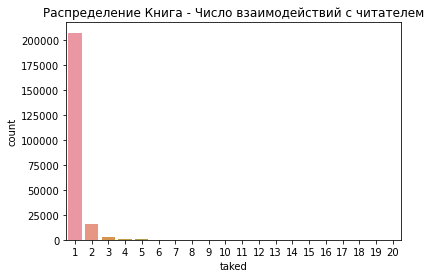

In [19]:
sns.countplot(x = "taked" , data  = train_transactions).set_title('Распределение Книга - Число взаимодействий с читателем')

В подавляющем большинстве случаев книгу берут единственный раз

In [20]:
# проверим, сколько наименований книг приходится на одного читателя
train_book_per_user = train_transactions[['chb', 'sys_numb', 'taked']].groupby(['chb', 'taked']).size().to_frame('Books').reset_index().sort_values('Books')
train_book_per_user

,chb,taked,Books
10973,200001084452,1,1
5343,200000897194,6,1
18247,300000993621,5,1
5337,200000896658,3,1
5336,200000896658,2,1
...,...,...,...
12634,200001132993,1,1146
16702,300000933517,1,1261
13553,300000758346,1,1642
3806,200000789223,1,3415


Как выяснилось, мы должны дать рекомендации и тем, кто брал 2 книги 2 раза, и тем, кто брал 6671 книги

In [21]:
# число взаимодействий пользователя 300001122685 
train_book_per_user[train_book_per_user['chb'] == '200000872413'].sort_values('Books')

,chb,taked,Books
5014,200000872413,4,1
5013,200000872413,3,3
5012,200000872413,2,85
5011,200000872413,1,6582


In [22]:
train_transactions[train_transactions['chb'] == '100000989544'].sort_values('taked', ascending=False)

,chb,sys_numb,taked
22664,100000989544,RSL01005233583,2
22622,100000989544,RSL01000570745,1
22671,100000989544,RSL01005345345,1
22678,100000989544,RSL01006278909,1
22677,100000989544,RSL01006016871,1
...,...,...,...
22647,100000989544,RSL01004985024,1
22646,100000989544,RSL01004873271,1
22645,100000989544,RSL01004383170,1
22644,100000989544,RSL01004328112,1


Даже пользователь, взявший 6671 книг имеет свои предпочтения и определенные книги берет чаще

Text(0.5, 1.0, 'Распределение по количеству взятых книг')

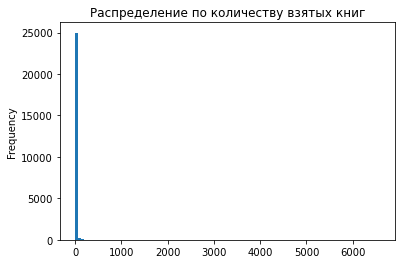

In [23]:
# посмотрим распределение
train_book_per_user["Books"].plot.hist(bins=100).set_title('Распределение по количеству взятых книг')

Text(0.5, 1.0, 'Распределение по количеству взятых книг')

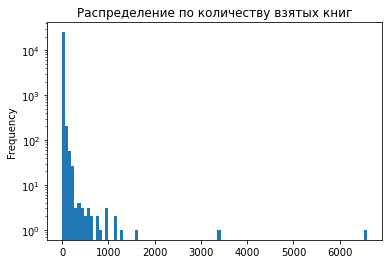

In [24]:
# для улучшения визуализации используем логарифмическую шкалу
train_book_per_user["Books"].plot.hist(bins=100, logy = True).set_title('Распределение по количеству взятых книг')

Судя по распределению, количество взятых книг не превышает, как правило, нескольких сотен

In [25]:
train_transactions['number_of_books'] = train_transactions.groupby(['chb', 'taked'])['taked'].transform('size')

train_transactions.sort_values('number_of_books')

,chb,sys_numb,taked,number_of_books
22664,100000989544,RSL01005233583,2,1
171779,300000968941,RSL01003615897,2,1
171882,300000969207,RSL01002635488,2,1
171951,300000969499,RSL01010106213,3,1
171967,300000969684,RSL01004066232,4,1
...,...,...,...,...
62486,200000872413,RSL01009499367,1,6582
62487,200000872413,RSL01009499378,1,6582
62488,200000872413,RSL01009499432,1,6582
62490,200000872413,RSL01009499863,1,6582


In [26]:
train_transactions[train_transactions['chb'] == '200000872413'].sort_values('number_of_books')

,chb,sys_numb,taked,number_of_books
64518,200000872413,RSL01010172357,4,1
61741,200000872413,RSL01008776382,3,3
60725,200000872413,RSL01008648818,3,3
63474,200000872413,RSL01010170230,3,3
64238,200000872413,RSL01010171785,2,85
...,...,...,...,...
61105,200000872413,RSL01008683842,1,6582
61104,200000872413,RSL01008683825,1,6582
61103,200000872413,RSL01008683725,1,6582
61113,200000872413,RSL01008684386,1,6582


In [27]:
train_transactions['max_taked'] = train_transactions.groupby(['chb'])['taked'].transform('max')

train_transactions.sort_values('number_of_books')

,chb,sys_numb,taked,number_of_books,max_taked
22664,100000989544,RSL01005233583,2,1,2
171779,300000968941,RSL01003615897,2,1,2
171882,300000969207,RSL01002635488,2,1,2
171951,300000969499,RSL01010106213,3,1,3
171967,300000969684,RSL01004066232,4,1,4
...,...,...,...,...,...
62486,200000872413,RSL01009499367,1,6582,4
62487,200000872413,RSL01009499378,1,6582,4
62488,200000872413,RSL01009499432,1,6582,4
62490,200000872413,RSL01009499863,1,6582,4


У нас есть следующие данные:\
**chb** - читатель\
**sys_numb** -  системный номер документа\
**taked** - сколько раз читатель взял книгу\
**number_of_books** - количество книг, которое читатель взял определенное число раз\
**max_taked** - максимальное число взаимодействий читателя с одной книгой

In [28]:
# пример для самого "читающего" пользователя 200000872413
train_transactions[train_transactions['chb'] == '200000872413'].sort_values('taked')

,chb,sys_numb,taked,number_of_books,max_taked
58867,200000872413,RSL01000306525,1,6582,4
63298,200000872413,RSL01009825267,1,6582,4
63297,200000872413,RSL01009825049,1,6582,4
63296,200000872413,RSL01009824744,1,6582,4
63295,200000872413,RSL01009822307,1,6582,4
...,...,...,...,...,...
64672,200000872413,RSL01010172650,2,85,4
60725,200000872413,RSL01008648818,3,3,4
61741,200000872413,RSL01008776382,3,3,4
63474,200000872413,RSL01010170230,3,3,4


# Добавление рейтинга книг

In [29]:
train_transactions['rating'] = train_transactions['taked']/train_transactions['max_taked']/train_transactions['number_of_books']*20
train_transactions[train_transactions['chb'] == '200000872413'].sort_values('rating')

,chb,sys_numb,taked,number_of_books,max_taked,rating
58867,200000872413,RSL01000306525,1,6582,4,0.000760
63298,200000872413,RSL01009825267,1,6582,4,0.000760
63297,200000872413,RSL01009825049,1,6582,4,0.000760
63296,200000872413,RSL01009824744,1,6582,4,0.000760
63295,200000872413,RSL01009822307,1,6582,4,0.000760
...,...,...,...,...,...,...
64672,200000872413,RSL01010172650,2,85,4,0.117647
60725,200000872413,RSL01008648818,3,3,4,5.000000
61741,200000872413,RSL01008776382,3,3,4,5.000000
63474,200000872413,RSL01010170230,3,3,4,5.000000


Text(0.5, 1.0, 'Распределение ratings')

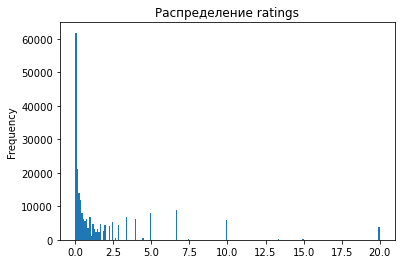

In [30]:
# sns.countplot(x = "rating" , data  = train_transactions).set_title('Распределение ratings')
train_transactions["rating"].plot.hist(bins=200).set_title('Распределение ratings')

In [34]:
train_transactions.sort_values('rating')

,chb,sys_numb,taked,number_of_books,max_taked,rating
60474,200000872413,RSL01008565791,1,6582,4,0.00076
62152,200000872413,RSL01008938743,1,6582,4,0.00076
62153,200000872413,RSL01008938793,1,6582,4,0.00076
62154,200000872413,RSL01008939541,1,6582,4,0.00076
62155,200000872413,RSL01008939757,1,6582,4,0.00076
...,...,...,...,...,...,...
91757,200001014036,RSL01010625079,5,1,5,20.00000
91926,200001015362,RSL01005371579,2,1,2,20.00000
91933,200001015405,RSL01003421956,2,1,2,20.00000
91559,200001013571,RSL01002413977,2,1,2,20.00000


# Создание частотного списка

In [35]:
train_transactions = train_transactions.merge(items[['title', 'sys_numb']], on=['sys_numb'])

In [36]:
train_transactions['title'] = train_transactions['title'].str.lower()
train_transactions.sort_values('rating')

,chb,sys_numb,taked,number_of_books,max_taked,rating,title
76262,200000872413,RSL01008789367,1,6582,4,0.00076,устройства бесконтактного контроля токопроводящих покрытий топливных баков летательных аппаратов : диссертация .. кандидата технических наук : 05.13.05
77772,200000872413,RSL01009862694,1,6582,4,0.00076,биоэкологическая характеристика комплексного прогнозируемого воздействия балтийской аэс на экосистему реки неман : диссертация .. кандидата биологических наук : 03.02.08
77773,200000872413,RSL01009862889,1,6582,4,0.00076,финансирование переселенческого дела на восточных окраинах российской империи : государственная политика и практики второй половины xix - начала xx вв. : диссертация .. кандидата исторических наук : 07.00.02
77774,200000872413,RSL01009863076,1,6582,4,0.00076,государственная власть и русская православная церковь в ссср в зеркале персональной истории : на примере общественной и церковной деятельности митрополита гурия (егорова) : диссертация .. кандидата исторических наук : 07.00.02
78704,200000872413,RSL01010171913,1,6582,4,0.00076,особенности адаптационных возможностей студентов с разными индивидуально-типологическими характеристиками психической деятельности и вегетативной регуляции организма : диссертация .. кандидата медицинских наук : специальность: 03.03.01 нормальная физиология
...,...,...,...,...,...,...,...
183671,300000956433,RSL01003258646,2,1,2,20.00000,балканский фактор европейской международно-политической системы и внешняя политика россии на рубеже xix-xx вв. : автореферат дис.. кандидата исторических наук : 07.00.03
183620,300000955930,RSL01003070234,2,1,2,20.00000,"средства создания комического в видеовербальном тексте : на материале английского юмористического сериала ""monty python flying circus"" : автореферат дис.. кандидата филологических наук : 10.02.04"
87390,200000916398,RSL01005080308,2,1,2,20.00000,новые технологии в обучении иностранным языкам : сборник статей региональной научно-практической студенческой конференции
86688,300000880686,RSL01008157121,2,1,2,20.00000,передвижники : между коммерческим товариществом и художественным движением


In [37]:
train_transactions['title'] = train_transactions['title'].str.replace(r"[^a-zа-я\s]", "")

C:\Users\User\AppData\Local\Temp/ipykernel_9852/595312528.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_transactions['title'] = train_transactions['title'].str.replace(r"[^a-zа-я\s]", "")


In [38]:
train_transactions.sort_values('rating')

,chb,sys_numb,taked,number_of_books,max_taked,rating,title
76262,200000872413,RSL01008789367,1,6582,4,0.00076,устройства бесконтактного контроля токопроводящих покрытий топливных баков летательных аппаратов диссертация кандидата технических наук
77772,200000872413,RSL01009862694,1,6582,4,0.00076,биоэкологическая характеристика комплексного прогнозируемого воздействия балтийской аэс на экосистему реки неман диссертация кандидата биологических наук
77773,200000872413,RSL01009862889,1,6582,4,0.00076,финансирование переселенческого дела на восточных окраинах российской империи государственная политика и практики второй половины xix начала xx вв диссертация кандидата исторических наук
77774,200000872413,RSL01009863076,1,6582,4,0.00076,государственная власть и русская православная церковь в ссср в зеркале персональной истории на примере общественной и церковной деятельности митрополита гурия егорова диссертация кандидата исторических наук
78704,200000872413,RSL01010171913,1,6582,4,0.00076,особенности адаптационных возможностей студентов с разными индивидуальнотипологическими характеристиками психической деятельности и вегетативной регуляции организма диссертация кандидата медицинских наук специальность нормальная физиология
...,...,...,...,...,...,...,...
183671,300000956433,RSL01003258646,2,1,2,20.00000,балканский фактор европейской международнополитической системы и внешняя политика россии на рубеже xixxx вв автореферат дис кандидата исторических наук
183620,300000955930,RSL01003070234,2,1,2,20.00000,средства создания комического в видеовербальном тексте на материале английского юмористического сериала monty python flying circus автореферат дис кандидата филологических наук
87390,200000916398,RSL01005080308,2,1,2,20.00000,новые технологии в обучении иностранным языкам сборник статей региональной научнопрактической студенческой конференции
86688,300000880686,RSL01008157121,2,1,2,20.00000,передвижники между коммерческим товариществом и художественным движением


In [39]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', None)

frequency_list = train_transactions.groupby(['chb'])['title'].agg(' '.join).reset_index(name='titles_sum')

# df1 = df.groupby('col')['val'].agg('-'.join).reset_index(name='new')

In [40]:
frequency_list.head(3)

,chb,titles_sum
0,100000641403,медицинская научная и общественная деятельность студентов военномедицинской академии в гг автореферат дис кандидата медицинских наук придание огнестойкости деревянным постройкам кирпичная изба
1,100000644359,медали в честь александра сергеевича пушкина синтез и свойства новых гетероциклических соединений на основе функциональных производных бензофуроксанов диссертация кандидата химических наук сравнительная цитогенетика эмбриобласта трофобласта и внутриполостной жидкости бластоцисты человека диссертация кандидата биологических наук разработка энергетических мультигенерирующих установок на базе дга диссертация кандидата технических наук разработка метода проектирования высокоэффективных гидроагрегатов микрогэс на напоры до м для комбинированных источников энергии диссертация кандидата технических наук развитие метода акустической эмиссии за счет автоматизации обработки данных повышения помехоустойчивости и достоверности обнаружения трещиноподобных дефектов металлоконструкций диссертация доктора технических наук методы и алгоритмы интеллектуального анализа данных о сложных проблемных ситуациях с использованием нейросетевого подхода диссертация кандидата технических наук правовое регулирование ответственности за нарушение налогового законодательства в соединенных штатах америки диссертация кандидата юридических наук обобщнные инварианты хованова узлов в прямоугольных представлениях диссертация кандидата физикоматематических наук семантика традиционной танцевальной культуры тувинцев автореферат дис кандидата культурологии методы и алгоритмы штрихового кодирования для задач лицевой биометрии диссертация кандидата технических наук
2,100000665127,проблема национального самосознания в идеологии бурятского просвещения автореферат дис кандидата философских наук власть и вера государство и религиозные институты в истории и современности творчество пи мельниковапечорского и изображение старообрядчества в русской литературе xix века автореферат дис кандидата филологических наук циклизация как принцип поэтики пи мельниковапечерского на материале произведений х гг автореферат дис кандидата филологических наук буддийское духовенство в социальнополитической истории калмыцкого ханства xviixviii вв автореферат дис кандидата исторических наук национальный образ мира в русской литературе пи мельниковпечерский ис шмелев аи солженицын автореферат дис доктора филологических наук раскольнические типы в беллетристических произведениях пи мельникова печерского раскольники в россии извлечения из распоряжений по делам о раскольниках при императорах николае и александре ii пополненные запискою пи мельниковапечерского полное собрание сочинений пи мельникова андрея печерского очерки мордвы дорожные записки на пути из тамбовской губернии в сибирь статьи исторического содержания полное собрание сочинений пи мельникова андрея печерского княжна тараканова и принцесса владимирская семейство богачевых старина балахонцовы полное собрание сочинений пи мельникова андрея печерского т ч полное собрание сочинений пи мельникова андрея печерского на горах роман в ч ч полное собрание сочинений пи мельникова андрея печерского т ч полное собрание сочинений пи мельникова андрея печерского в лесах роман в ч ч полное собрание сочинений пи мельникова андрея печерского павел иванович мельников его жизнь и литературная деятельность бузавы очерки истории донских калмыцких станиц нива г полное собрание сочинений п и мельниковапечерского плакат


In [41]:
import nltk
# nltk.download('punkt')
from nltk.probability import FreqDist
from nltk.corpus import stopwords
# nltk.download('stopwords')
from nltk import word_tokenize


In [42]:
def frequency_analysis(text):
    text_tokens = word_tokenize(text)
    russian_stopwords = stopwords.words("russian")
    russian_stopwords.extend(['это', 'нею', 'н', 'ч','х','б','м','г','т','ф','е','й','п','л','д',
'ю','w','i','р','э','a','з','c','g','пи','гг','ба','др','of','кн','ii','ам','хх','яз','xx','сб','in',
'цк','de','et','го','вс','th','вв','on','to','аа','мм','нф','ст','xv','la','аф','фр','нв','ар','ах','кл','мю',
'ми','ес', 'гр', 'ан', 'фм', 'вм', 'en', 'гл', 'ад', 'ап', 'ис', 'фз', 'св', 'мл', 'sa', 'ак', 'ix', 'iv', 'ex', 
                              'ся', 'вып', 'дис', 'the', 'пер', 'and', 'гос', 'smm', 'xix', 'док', 'des', 'ред', 
                              'ума', 'год', 'сэв', 'сми', 'for', 'нтв', 'миф', 'сел', 'сов', 'дач', 'iii', 'вся', 
                              'мвд', 'дон', 'обл', 'ход', 'der', 'law', 'гто', 'мир', 'fin', 'von', 'арх', 'снг', 
                              'быт', 'рус', 'рек', 'рос', 'оао', 'сср', 'жен', 'лит', 'рак', 'век', 'лет', 'сша', 
                              'ран', 'чай', 'xxx', 'пбу', 'xxi', 'рим', 'дом', 'par', 'тнк', 'ipo', 'дни', 'рок', 
                              'апк', 'окр', 'дня', 'мво', 'инт', 'лев', 'соч', 'his', 'тел', 'les', 'фет', 'кнр', 
                              'общ', 'уст', 'xvi', 'дпо', 'еда', 'ans', 'not', 'ваз', 'сил', 'шуи', 'css', 'бка', 
                              'чая', 'нло', 'пот', 'дао', 'hbr', 'фак', 'бсм', 'изд', 'ибо', 'tir', 'мои', 'экг', 
                              'und', 'дел', 'жил', 'мед', 'егэ', 'die', 'вне', 'янв', 'лиц', 'фон', 'жан', 'окт', 
                              'авт', 'ист', 'оон', 'оиф', 'квн', 'uml', 'суд', 'sap', 'шаг', 'нлп', 'фрг', 'big', 
                              'мгу', 'рун', 'дра', 'how', 'art', 'рай', 'физ', 'пол', 'оды', 'код', 'орл', 'шут', 'php' ])

    text_tokens = [token.strip() for token in text_tokens if token not in russian_stopwords]
    text = nltk.Text(text_tokens)
    fdist_sw = FreqDist(text)
    return fdist_sw.most_common(2)

In [43]:
frequency_analysis(frequency_list.loc[frequency_list.chb == '100000641403', 'titles_sum'].values[0])[1][0]

'научная'

In [44]:
frequency_list[frequency_list.chb == '100000641403']

,chb,titles_sum
0,100000641403,медицинская научная и общественная деятельность студентов военномедицинской академии в гг автореферат дис кандидата медицинских наук придание огнестойкости деревянным постройкам кирпичная изба


In [45]:
for line in frequency_list.itertuples():
    words = frequency_analysis(frequency_list.loc[frequency_list.chb == line.chb, 'titles_sum'].values[0])
    word_num = 0
    while word_num < len(words):
        frequency_list.loc[(frequency_list.chb == line.chb), f'relevant_words{word_num}'] = words[word_num][0]
        word_num += 1
   

In [46]:
frequency_list

chb  \
0      100000641403   
1      100000644359   
2      100000665127   
3      100000676191   
4      100000679200   
...             ...   
16748  300001170610   
16749  300001172682   
16750  300001172795   
16751  300001173062   
16752  400001035059   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [47]:
for line in train_transactions.itertuples():
    text = line.title.split()
    checklist = frequency_list.loc[(frequency_list.chb == line.chb), 'relevant_words1']
    for word in checklist:
        if str(word) in text:
            train_transactions.loc[(train_transactions.sys_numb == line.sys_numb), 'rating'] = 19 *\
            train_transactions['taked']/train_transactions['max_taked']

In [48]:
train_transactions[train_transactions['chb'] == '100000641403'].sort_values('rating')

,chb,sys_numb,taked,number_of_books,max_taked,rating,title
1,100000641403,RSL01004206702,1,3,1,6.666667,придание огнестойкости деревянным постройкам
2,100000641403,RSL01004211574,1,3,1,6.666667,кирпичная изба
0,100000641403,RSL01000769304,1,3,1,19.000000,медицинская научная и общественная деятельность студентов военномедицинской академии в гг автореферат дис кандидата медицинских наук


Text(0.5, 1.0, 'Распределение ratings')

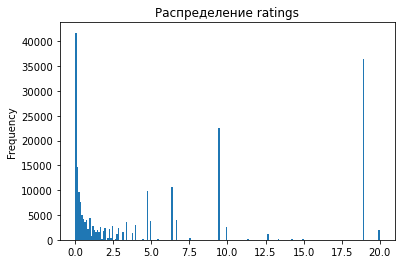

In [49]:
train_transactions["rating"].plot.hist(bins=200).set_title('Распределение ratings')

In [50]:
for line in train_transactions.itertuples():
    text = line.title.split()
    checklist = frequency_list.loc[(frequency_list.chb == line.chb), 'relevant_words0']
    for word in checklist:
        if str(word) in text:
            train_transactions.loc[(train_transactions.sys_numb == line.sys_numb), 'rating'] = 20 *\
            train_transactions['taked']/train_transactions['max_taked']

In [51]:
train_transactions[train_transactions['chb'] == '100000641403'].sort_values('rating')

,chb,sys_numb,taked,number_of_books,max_taked,rating,title
1,100000641403,RSL01004206702,1,3,1,6.666667,придание огнестойкости деревянным постройкам
2,100000641403,RSL01004211574,1,3,1,6.666667,кирпичная изба
0,100000641403,RSL01000769304,1,3,1,20.000000,медицинская научная и общественная деятельность студентов военномедицинской академии в гг автореферат дис кандидата медицинских наук


Text(0.5, 1.0, 'Распределение ratings')

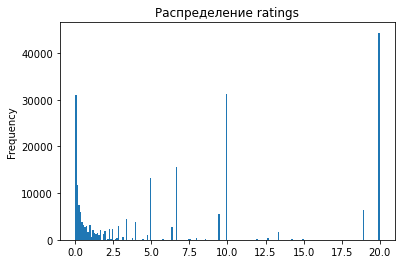

In [52]:
train_transactions["rating"].plot.hist(bins=200).set_title('Распределение ratings')

In [53]:
pd.set_option('display.max_rows', 25)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', None)


In [55]:
train_transactions.nunique()

chb                 16753
sys_numb           194666
taked                  20
number_of_books       211
max_taked              20
rating                625
title              173192
dtype: int64

In [56]:
#т.к далее придётся работать с матрицами созданим словари, которые точно отображают индексы в chb/sys_numb и обратно
mapping_chb_index = {chb_number: index for index, chb_number in enumerate(train_transactions['chb'].unique())}
mapping_sys_numb_index = {sys_number: index for index, sys_number in enumerate(train_transactions['sys_numb'].unique())}

mapping_index_chb = {index: chb_number for index, chb_number in enumerate(train_transactions['chb'].unique())}
mapping_index_sys_numb = {index: sys_number for index, sys_number in enumerate(train_transactions['sys_numb'].unique())}

In [57]:
from sklearn.model_selection import train_test_split

# делим данные на тренировочный и тестовый наборы
train_data, test_data = train_test_split(train_transactions, test_size=0.3, stratify=train_transactions['chb'])

In [58]:
train_data.nunique()

chb                 16753
sys_numb           141852
taked                  19
number_of_books       211
max_taked              20
rating                610
title              126956
dtype: int64

In [59]:
# в выборке для тестирования присутствуют все пользователи. 

print(f"Кол-во уникальных пользователей: {len(train_transactions['chb'].unique())}")
print(f"Кол-во уникальных пользователей в выборке для обучения: {len(train_data['chb'].unique())}")
print(f"Кол-во уникальных пользователей в выборке для тестирования: {len(test_data['chb'].unique())}")

Кол-во уникальных пользователей: 16753
Кол-во уникальных пользователей в выборке для обучения: 16753
Кол-во уникальных пользователей в выборке для тестирования: 16753


In [60]:
# Имеем дело с разряженными матрицами с ними лучше работать в sparse формате

def df_to_sparse(df):
    row = []
    col = []
    data = []

    for line in df.itertuples():
        row.append(mapping_chb_index[line.chb])
        col.append(mapping_sys_numb_index[line.sys_numb])
        data.append(line.rating)

    return csr_matrix((data, (row, col)))

In [61]:
# получение sparse матрицы user-item для train/test
train_data_sparse = df_to_sparse(train_transactions)
test_data_sparse = df_to_sparse(test_data)

In [62]:
train_data_sparse.shape

(16753, 194666)

# Построение модели с помощью алгоритма ALS

In [63]:
from implicit.als import AlternatingLeastSquares
# AlternatingLeastSquares?

In [65]:
# Создаем модель
model = AlternatingLeastSquares(factors=20, iterations=15, alpha = 20)
model.fit(train_data_sparse)

  0%|          | 0/50 [00:00<?, ?it/s]

In [66]:
# Получим рекомендации для конкретного пользователя 
userid = 2233
ids, scores = model.recommend(userid, train_data_sparse[userid], N=20, filter_already_liked_items=False)

In [67]:
# Отобразим рекомендации в DataFrame
top20recom_df = pd.DataFrame({"sys_numb": [mapping_index_sys_numb[id] for id in ids], "score": scores, "already_liked": np.in1d(ids, train_data_sparse[userid].indices)})

In [68]:
top20recom_df

,sys_numb,score,already_liked
0,RSL01002917145,0.675469,True
1,RSL01004479890,0.509975,True
2,RSL01009618059,0.509972,True
3,RSL01004898666,0.509972,True
4,RSL01004970585,0.509967,True
5,RSL01003443677,0.327824,False
6,RSL01003539006,0.307345,False
7,RSL01002589086,0.291215,False
8,RSL01002349089,0.279151,False
9,RSL01010337581,0.268866,False


In [69]:
def get_recom(userid):
    ids, scores = model.recommend(userid, train_data_sparse[userid], N=20, filter_already_liked_items=False)
    top20recom_df = pd.DataFrame({"sys_numb": [mapping_index_sys_numb[id] for id in ids], "score": scores, "already_liked": np.in1d(ids, train_data_sparse[userid].indices)})
    return top20recom_df['sys_numb'].values

In [70]:
#подбор рекомендаций для всех пользователей из train

all_rec = []

for userid in tqdm(range(train_data_sparse.shape[0])):
    user_chb = mapping_index_chb[userid]
    user_rec = get_recom(userid)
    for rec in user_rec:
        all_rec.append([user_chb, rec])

  0%|          | 0/16753 [00:00<?, ?it/s]

In [71]:
# DataFrame для отправки решения с рекомендациями
solution = pd.DataFrame(all_rec, columns=["chb", "sys_numb"])

In [72]:
# Формирование csv файла для отправки на платформу
solution.to_csv("solution59.csv", index=False, sep=';')

## Метрика

In [73]:
df_solution = solution
df_grd = test_data

In [74]:
#считаем recall, precision, f1_score

def metric(df_solution, df_grd):
    pred = set(df_solution['chb'] + '_' + df_solution['sys_numb'].values)
    true = set(df_grd['chb'] + '_' + df_grd['sys_numb'].values)
    recall = len(pred.intersection(true)) / len(true)
    precision = len(pred.intersection(true)) / (20 * len(df_grd['chb'].unique()))
    f1_score = 2 * (precision * recall) / (precision + recall)
    print(f"Recall: {round(recall, 5)}")
    print(f"Precision: {round(precision, 5)}")
    print(f"F1-score: {round(f1_score, 5)}")

In [75]:
# оценка базового решения

metric(df_solution, df_grd)

Recall: 0.36247
Precision: 0.07432
F1-score: 0.12335


Recall: 0.45836
Precision: 0.09398
F1-score: 0.15598 iterations=30, alpha = 90

Recall: 0.47523
Precision: 0.09744
F1-score: 0.16172 iterations=100, alpha = 250

Recall: 0.39937
Precision: 0.08189
F1-score: 0.13591 iterations=50, alpha = 42

Recall: 0.4098
Precision: 0.08403
F1-score: 0.13946 iterations=50, alpha = 200

Recall: 0.48957
Precision: 0.096
F1-score: 0.16052 factors=200, iterations=50, alpha = 200

Recall: 0.51441
Precision: 0.09672
F1-score: 0.16282 factors=200, iterations=100, alpha = 350

Recall: 0.50392
Precision: 0.10332
F1-score: 0.17149 factors=200, iterations=50, alpha = 350

Recall: 0.47321
Precision: 0.09703
F1-score: 0.16104 factors=200, iterations=100, alpha = 350

Recall: 0.08908
Precision: 0.01827
F1-score: 0.03031 alpha = 2

Recall: 0.32525
Precision: 0.06669
F1-score: 0.11068 alpha = 100

Recall: 0.35465
Precision: 0.07272
F1-score: 0.12069 alpha = 150

Recall: 0.37439
Precision: 0.07677
F1-score: 0.12741 alpha = 200

Recall: 0.39126
Precision: 0.08022
F1-score: 0.13315 alpha = 250

Recall: 0.40452
Precision: 0.08294
F1-score: 0.13766 alpha = 300

Recall: 0.41513
Precision: 0.08512
F1-score: 0.14127 alpha = 350

Recall: 0.40439
Precision: 0.08292
F1-score: 0.13762 alpha = 400\


Recall: 0.44954
Precision: 0.09217
F1-score: 0.15298 iterations=50, alpha = 350

Recall: 0.4078
Precision: 0.08361
F1-score: 0.13878 iterations=50, alpha = 200

regularization=0\
Recall: 0.41438
Precision: 0.08496
F1-score: 0.14101 alpha = 350

In [76]:
# подадим ответы в качестве рекомендаций

metric(df_grd, df_grd)

Recall: 1.0
Precision: 0.20504
F1-score: 0.34031


In [77]:
# создадим случайные рекомендации 
random_solution = []
for chb in tqdm(set(df_grd['chb'].values)):
    for sys in items['sys_numb'].sample(20).values:
        random_solution.append([chb, sys])

  0%|          | 0/16753 [00:00<?, ?it/s]

In [78]:
# оценка подхода со случайными рекомендациями
metric(pd.DataFrame(random_solution, columns=['chb', 'sys_numb']), df_grd)

Recall: 7e-05
Precision: 1e-05
F1-score: 2e-05
